In [62]:
!pip uninstall -y torch torchvision torchtext
!pip install torch==2.3.0 torchtext==0.18.0 torchvision

Found existing installation: torch 2.3.0
Uninstalling torch-2.3.0:
  Successfully uninstalled torch-2.3.0
Found existing installation: torchvision 0.18.0
Uninstalling torchvision-0.18.0:
  Successfully uninstalled torchvision-0.18.0
Found existing installation: torchtext 0.18.0
Uninstalling torchtext-0.18.0:
  Successfully uninstalled torchtext-0.18.0
  Using cached torch-2.3.0-cp310-none-macosx_11_0_arm64.whl.metadata (26 kB)
  Using cached torchtext-0.18.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (7.9 kB)
  Using cached torchvision-0.22.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.1 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached torchvision-0.22.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached torchvision-0.21.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.1 kB)
  Using cached torchvision-0.20.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (6

In [63]:
!pip install datasets evaluate --upgrade

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
import torchtext
import tqdm
import evaluate

**load your datasets**

In [65]:
dataset = datasets.load_dataset("bentrevett/multi30k")

In [66]:
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [67]:
train_data,valid_data,test_data=(dataset["train"],dataset["validation"],dataset["test"])

In [68]:
train_data

Dataset({
    features: ['en', 'de'],
    num_rows: 29000
})

In [69]:
valid_data

Dataset({
    features: ['en', 'de'],
    num_rows: 1014
})

In [70]:
test_data

Dataset({
    features: ['en', 'de'],
    num_rows: 1000
})

In [71]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

In [72]:
test_data[0]

{'en': 'A man in an orange hat starring at something.',
 'de': 'Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.'}

**Tokenize Data**

In [73]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.3 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 36.0 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [74]:
en_nlp=spacy.load("en_core_web_sm")
de_nlp=spacy.load("de_core_news_sm")

In [75]:
string="how are you !"

In [76]:
[token.text for token in en_nlp.tokenizer(string)]

['how', 'are', 'you', '!']

In [77]:
def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):

    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]

    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]

    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

In [78]:
train_data

Dataset({
    features: ['en', 'de', 'en_tokens', 'de_tokens'],
    num_rows: 29000
})

In [79]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>']}

**creating vocabulary**

In [80]:
from torchtext.vocab import build_vocab_from_iterator

In [81]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

de_vocab = build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [82]:
len(en_vocab)

5893

In [83]:
len(de_vocab)

7853

In [84]:
en_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man']

In [85]:
en_vocab.get_itos()[9]

'man'

In [86]:
en_vocab.get_stoi()["man"]

9

In [87]:
en_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man']

In [88]:
# Checking the unkown and padding token indexing. 
assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [89]:
# setting the unknown indexing as zero. 
en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(pad_index)

In [90]:
en_vocab["nsdjksf"]

0

In [91]:
de_vocab["nsdjksf"]

1

In [92]:
tokens = ["My", "name", "is", "Netra Khatri"]
en_vocab.lookup_indices(tokens)

[0, 1507, 10, 0]

### **Numericalizing Data**

In [93]:
def numericalize_example(example, en_vocab, de_vocab):

    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    
    return {
        "en_ids": en_ids,
        "de_ids": de_ids
    }

fn_kwargs = {
    "en_vocab": en_vocab, 
    "de_vocab": de_vocab
}

# map always takes: function name, and function arugments. 
train_data = train_data.map(
    numericalize_example, 
    fn_kwargs = fn_kwargs
)

test_data = test_data.map(
    numericalize_example, 
    fn_kwargs = fn_kwargs
)

valid_data = valid_data.map(
    numericalize_example, 
    fn_kwargs = fn_kwargs
)

In [94]:
train_data

Dataset({
    features: ['en', 'de', 'en_tokens', 'de_tokens', 'en_ids', 'de_ids'],
    num_rows: 29000
})

In [95]:
train_data[0]["en_ids"]

[2, 16, 24, 15, 25, 778, 17, 57, 80, 202, 1312, 5, 3]

In [96]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>'],
 'en_ids': [2, 16, 24, 15, 25, 778, 17, 57, 80, 202, 1312, 5, 3],
 'de_ids': [2, 18, 26, 253, 30, 84, 20, 88, 7, 15, 110, 7647, 3171, 4, 3]}

### **Convert Data into tensors**

In [97]:
train_data

Dataset({
    features: ['en', 'de', 'en_tokens', 'de_tokens', 'en_ids', 'de_ids'],
    num_rows: 29000
})

In [98]:
data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type = data_type, 
    columns = format_columns,
    output_all_columns = True
)

valid_data = valid_data.with_format(
    type = data_type,
    columns = format_columns, 
    output_all_columns = True
)

test_data = test_data.with_format(
    type = data_type, 
    columns = format_columns, 
    output_all_columns = True
)

In [99]:
train_data[0]

{'en_ids': tensor([   2,   16,   24,   15,   25,  778,   17,   57,   80,  202, 1312,    5,
            3]),
 'de_ids': tensor([   2,   18,   26,  253,   30,   84,   20,   88,    7,   15,  110, 7647,
         3171,    4,    3]),
 'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>']}

In [100]:
type(train_data[0]["de_ids"])

torch.Tensor

### **Creating a DataLoaders**

In [101]:
batch_size = 128

def get_collate_fn(pad_index):

    def collate_fn(batch):

        batch_en_ids = [example["en_ids"] for example in batch] 
        batch_de_ids = [example["de_ids"] for example in batch]

        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)

        return {
            "en_ids": batch_en_ids, 
            "de_ids": batch_de_ids
        }
    
    return collate_fn

def get_data_loader(dataset, batch_size, pad_index, shuffle=False):

    collate_fn = get_collate_fn(pad_index)
    
    # Convert the data into the batches. 
    data_loader = torch.utils.data.DataLoader(
        dataset = dataset,
        batch_size = batch_size, 
        collate_fn = collate_fn, # Convert each rows into the numbers. 
        shuffle = shuffle
    ) # DataLoader helps to make the batches.

    return data_loader

train_data_loader = get_data_loader(
    train_data, 
    batch_size, 
    pad_index, # some of the rows are short and some are long, so adding pad_index = 1 is added. 
    shuffle=True
)

valid_data_loader = get_data_loader(
    valid_data, 
    batch_size, 
    pad_index
)

test_data_loader = get_data_loader(
    test_data, 
    batch_size, 
    pad_index
)

In [102]:
len(train_data_loader) # 227 batches, each batches contains 128 rows. 

227

In [103]:
len(test_data_loader) 

8

In [104]:
len(valid_data_loader)

8

### **Model Sequence to Sequence Models**

![Encoder and Decoder.png](<attachment:Encoder and Decoder.png>)
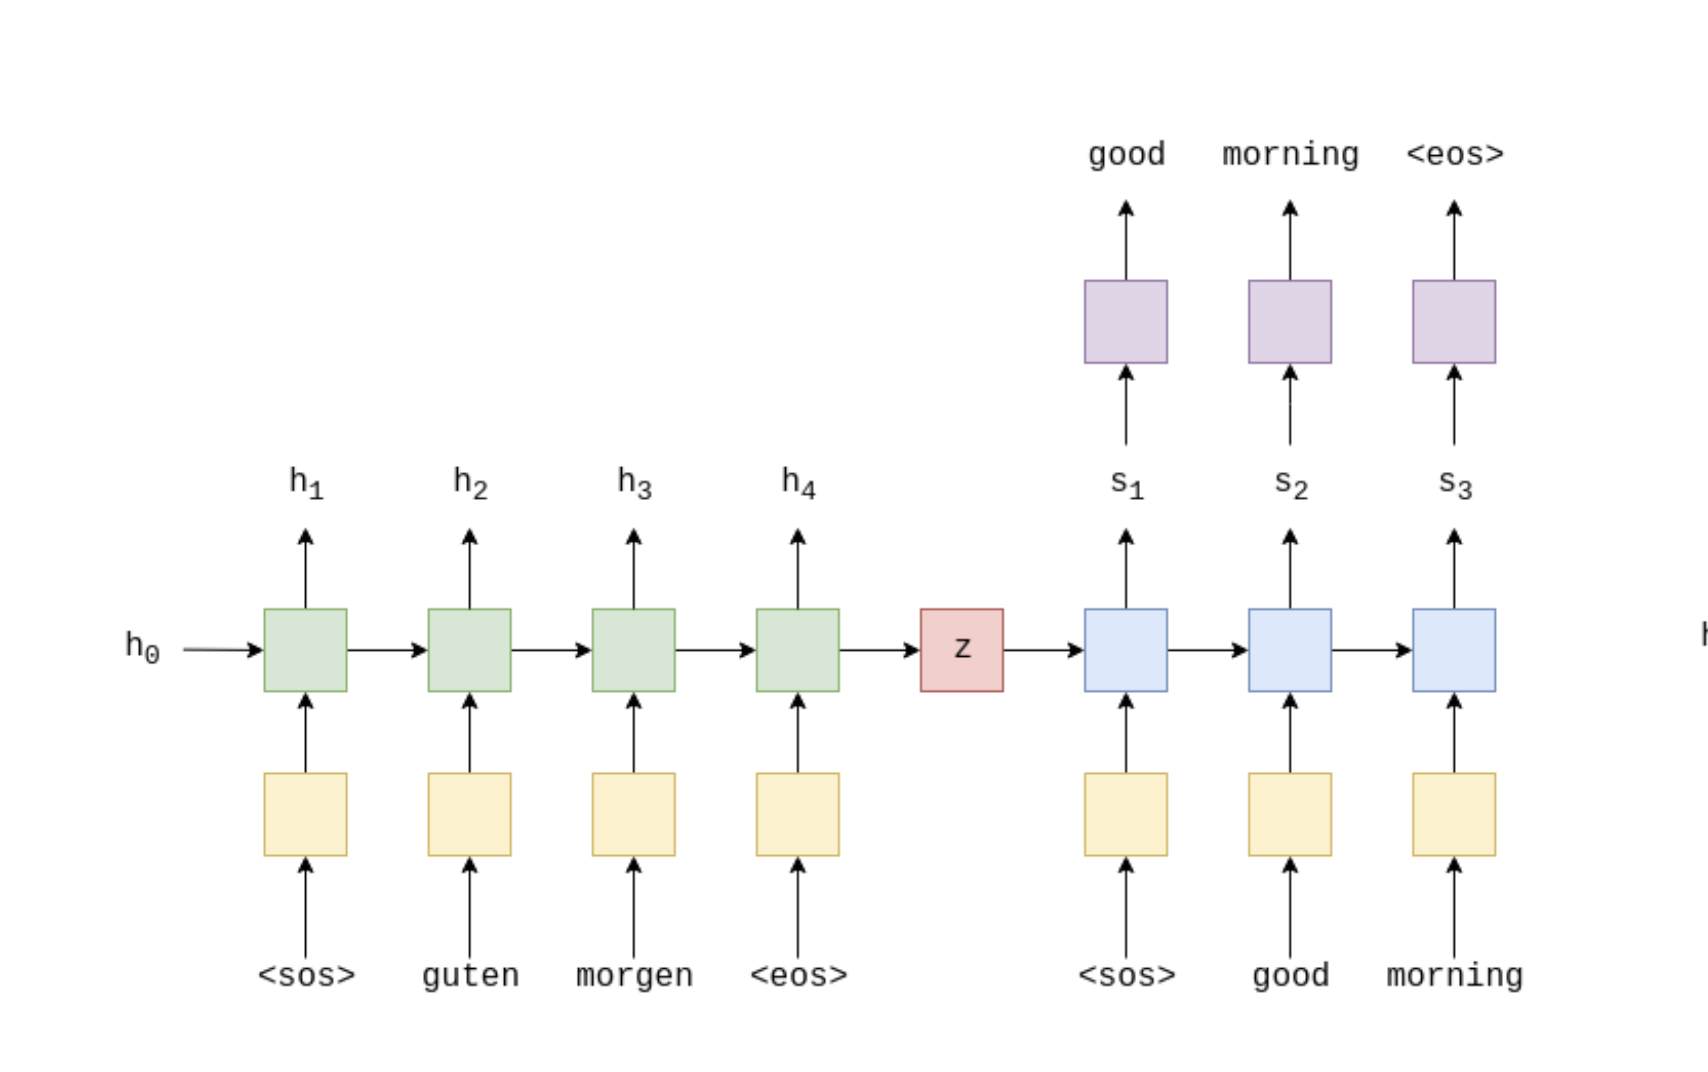

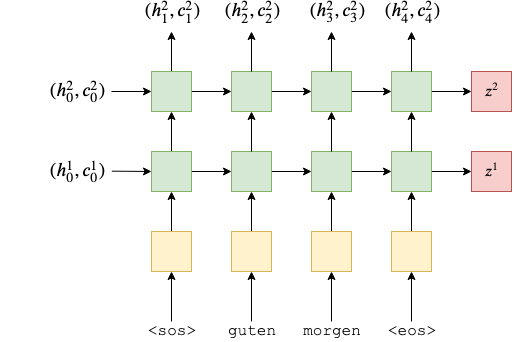

### **`Building Encoder`**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src):

        # src = [src length, batch size]

        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]

        outputs, (hidden, cell) = self.lstm(embedded)

        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer

        return hidden, cell

### **`Building Decoder`**

In [ ]:
# Decoder does not take whole input at once. 
# It takes one input at once. so that we have to add one dimension.
# we pass the <sos> at first. 
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        return prediction, hidden, cell


### **`Sequence2Sequence Model`**

In [110]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        # input = [batch size]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

### **`Model Initialialization`**

In [111]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

model = Seq2Seq(encoder, decoder, device).to(device)

### **`Weight Initialization`**

In [ ]:
'''Uniform Distribution (-0.08 +0.08)'''


'Uniform Distribution (-0.08 +0.08)'

In [113]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (lstm): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (lstm): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [116]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0631, -0.0533, -0.0726,  ..., -0.0640, -0.0503,  0.0469],
         [-0.0087,  0.0051, -0.0387,  ..., -0.0144, -0.0241, -0.0317],
         [ 0.0781, -0.0258,  0.0631,  ...,  0.0606,  0.0558, -0.0786],
         ...,
         [-0.0474,  0.0574, -0.0739,  ..., -0.0197, -0.0330, -0.0701],
         [ 0.0045,  0.0675, -0.0421,  ..., -0.0179, -0.0033,  0.0527],
         [ 0.0496,  0.0175, -0.0482,  ..., -0.0683,  0.0259,  0.0072]],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.0702,  0.0629, -0.0658,  ..., -0.0346,  0.0394, -0.0783],
         [-0.0016, -0.0176,  0.0049,  ..., -0.0748,  0.0215, -0.0660],
         [ 0.0539, -0.0531,  0.0239,  ...,  0.0179, -0.0068, -0.0790],
         ...,
         [ 0.0663, -0.0499, -0.0314,  ..., -0.0007,  0.0297,  0.0164],
         [ 0.0478,  0.0796,  0.0246,  ..., -0.0761,  0.0042,  0.0754],
         [ 0.0296,  0.0270,  0.0428,  ..., -0.0606, -0.0023, -0.0008]],
        requires_grad=True),
 Parameter con

In [117]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model): ,} trainable parameters")

The model has  13,898,501 trainable parameters


### **`Loss function & Optimizer`**

In [118]:
optimizer = optim.Adam(model.parameters())
criterion =nn.CrossEntropyLoss(ignore_index=pad_index)

In [119]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [120]:
criterion

CrossEntropyLoss()

### **`Training and Evaluating Functions`**

In [144]:
train_data

Dataset({
    features: ['en', 'de', 'en_tokens', 'de_tokens', 'en_ids', 'de_ids'],
    num_rows: 29000
})

In [143]:
len(train_data_loader)

227

In [ ]:
for i, batch in enumerate(train_data_loader):
    print("Index: ", i)
    print("Batch: ", batch["en_ids"])
    # [src_length, batch]
    break

Index:  0
Batch:  tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   4,   34,    4,  ...,   21,    4,    4],
        [ 221,   11,    9,  ...,  106,    9, 1861],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]])


In [ ]:
clip = 1.0
teacher_forcing_ratio = 0.5

def training_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(train_data_loader):
        src = batch["de_ids"].to(device)
        trg = batch["en_ids"].to(device)
        
        optimizer.zero_grad() 

        # model = Seq2Seq(encoder, decoder, device).to(device)
        output = model(src, trg, teacher_forcing_ratio)

def evaluating_fn():
    pass

**Encoder**

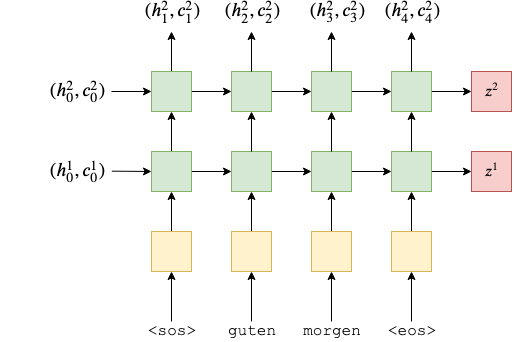

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, (hidden, cell) = self.lstm(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell


**Decoder**

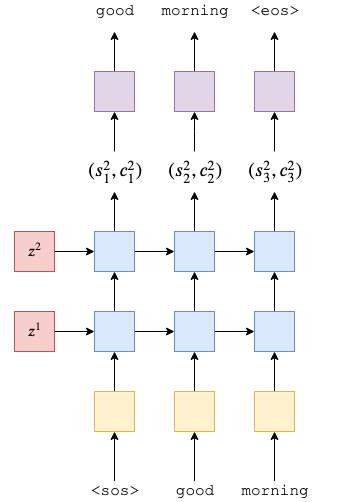

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        return prediction, hidden, cell


**Seq2Seq**

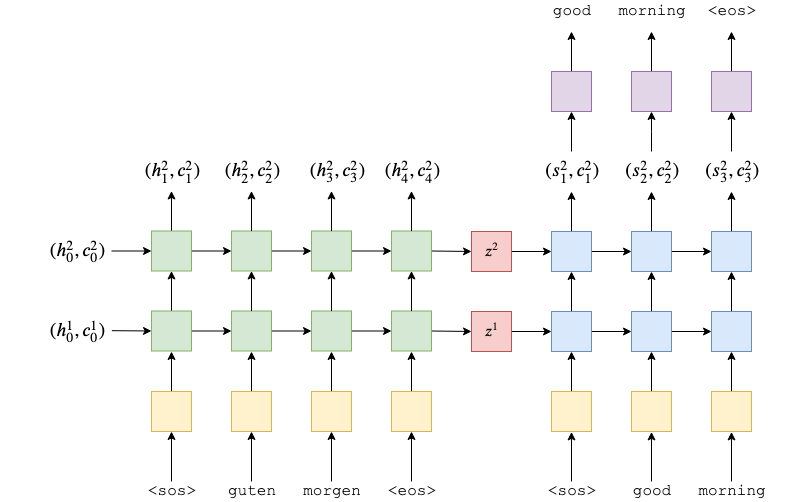

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        # input = [batch size]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

**Training the Model**


***Model Initialization***


In [ ]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

model = Seq2Seq(encoder, decoder, device).to(device)

**Weight Initialization**


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (lstm): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (lstm): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 13,898,501 trainable parameters


**Optimizer**


In [ ]:
optimizer = optim.Adam(model.parameters())


**Loss Function**

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)


**Training Loop**


In [ ]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["de_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [ ]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["de_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

**Model Training**


In [ ]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut1-model.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

  0%|          | 0/10 [02:00<?, ?it/s]


KeyboardInterrupt: 

**Evaluating the Model**


In [ ]:
model.load_state_dict(torch.load("tut1-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 3.908 | Test PPL:  49.808 |


In [ ]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]
        if lower:
            tokens = [token.lower() for token in tokens]
        tokens = [sos_token] + tokens + [eos_token]
        ids = de_vocab.lookup_indices(tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        hidden, cell = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        for _ in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        tokens = en_vocab.lookup_tokens(inputs)
    return tokens

In [ ]:
sentence = test_data[0]["de"]
expected_translation = test_data[0]["en"]

sentence, expected_translation

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'A man in an orange hat starring at something.')

In [ ]:
translation = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [ ]:
translation

['<sos>',
 'a',
 'man',
 'in',
 'a',
 'red',
 'hat',
 'is',
 'looking',
 'at',
 'something',
 '.',
 '<eos>']

In [ ]:
sentence = "Ein Mann sitzt auf einer Bank."


In [ ]:
translation = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [ ]:
translation


['<sos>', 'a', 'man', 'sits', 'on', 'a', 'bench', 'bench', '.', '<eos>']

In [ ]:
translations = [
    translate_sentence(
        example["de"],
        model,
        en_nlp,
        de_nlp,
        en_vocab,
        de_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )
    for example in tqdm.tqdm(test_data)
]

100%|██████████| 1000/1000 [00:09<00:00, 101.75it/s]


In [ ]:
bleu = evaluate.load("bleu")

In [ ]:
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]

In [ ]:
predictions[0], references[0]


('a man in a red hat is looking at something .',
 ['A man in an orange hat starring at something.'])

In [ ]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [ ]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)


In [ ]:
tokenizer_fn(predictions[0]), tokenizer_fn(references[0][0])


(['a',
  'man',
  'in',
  'a',
  'red',
  'hat',
  'is',
  'looking',
  'at',
  'something',
  '.'],
 ['a', 'man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something', '.'])

In [ ]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

In [ ]:
results

{'bleu': 0.12901202656282915,
 'precisions': [0.45495426829268293,
  0.17714521452145215,
  0.08282374100719425,
  0.041501976284584984],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0047480471741461,
 'translation_length': 13120,
 'reference_length': 13058}